<a href="https://colab.research.google.com/github/ystraore/Flight_Delay_Predictions_Model/blob/main/Project_2_(Final_Version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Categories of Flight Delay Among Popular Airlines
#### By Yssa Traore

#### Introduction and Problem Statement:
Flight delays are a significant concern in the aviation industry, impacting operational efficiency and passenger satisfaction. This study aims to develop a predictive model to categorize flight delays into three distinct categories: no delay, significant delay, and lengthy delay. These categories are defined based on the duration of the delay, with thresholds determined by the distribution of delay times in historical flight data.

The categorization is as follows:
- No Delay: Delays of 10 minutes or less, typically considered negligible in terms of impact on passengers' schedules.
- Moderate Delay: Delays between 10 to 30 minutes, which can cause inconvenience but are unlikely to severely disrupt travel plans.
- Lengthy Delay: Delays exceeding 30 minutes, often resulting in significant disruptions to travel schedules and plans.

The classification thresholds are established using the 0.33 and 0.66 quantiles of the delay duration distribution in the dataset, aligning with the practical implications of these delay durations from a traveler's perspective. The objective is to employ machine learning techniques to accurately predict the category of delay for a given flight, thereby aiding airlines and improving passenger experience through better communication and planning.

This model could serve as a tool for airlines and passengers, offering insights into potential delays and allowing for more informed decision-making regarding flight schedules and travel plans.

##Imports and initial dataset info

Dataset link: [DelayedFlights.csv](https://www.kaggle.com/datasets/giovamata/airlinedelaycauses/download?datasetVersionNumber=2)

Carrier Data Link: [L_UNIQUE_CARRIERS.csv](https://www.transtats.bts.gov/Download_Lookup.asp?Y11x72=Y_haVdhR_PNeeVRef)

Airport Data Link: [L_AIRPORT.csv](https://www.transtats.bts.gov/Download_Lookup.asp?Y11x72=Y_NVecbeg)

The main dataset, DelayedFlights, encompasses the data like where flights originated, the day and time of the flights, the month, taxi in time, and taxi out time, among others. Most of the information categorizing airlines and carriers use a proprietary encoding made by the Bureau of Transportation Statistics.

Both the Carrier and Airport Datasets are used to change these codes from the BTS standard to the actual names of the airlines and airports to improve the interpretability of the plots.

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Load the sample data
df = pd.read_csv('/content/DelayedFlights.csv')
carriers = pd.read_csv('/content/L_UNIQUE_CARRIERS (1).csv')
airports_df = pd.read_csv('/content/L_UNIQUE_CARRIERS (1).csv')
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82905 entries, 0 to 82904
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         82905 non-null  int64  
 1   Year               82905 non-null  int64  
 2   Month              82905 non-null  int64  
 3   DayofMonth         82905 non-null  int64  
 4   DayOfWeek          82905 non-null  int64  
 5   DepTime            82905 non-null  float64
 6   CRSDepTime         82905 non-null  int64  
 7   ArrTime            82629 non-null  float64
 8   CRSArrTime         82905 non-null  int64  
 9   UniqueCarrier      82905 non-null  object 
 10  FlightNum          82905 non-null  int64  
 11  TailNum            82905 non-null  object 
 12  ActualElapsedTime  82628 non-null  float64
 13  CRSElapsedTime     82904 non-null  float64
 14  AirTime            82628 non-null  float64
 15  ArrDelay           82628 non-null  float64
 16  DepDelay           829

Initial Preprocessing

The primary objective here is to ensure that it's easy to understand exactly what is in the columns we're going to be using. We also drop some unnecessary columns and create the variable we will be predicting, Delay Category.

In [7]:
# Renaming columns for clarity
rename_columns = {
    'DepTime': 'ActualDepartureTime',
    'CRSDepTime': 'ScheduledDepartureTime',
    'ArrTime': 'ActualArrivalTime',
    'CRSArrTime': 'ScheduledArrivalTime',
    'UniqueCarrier': 'CarrierCode',
    'ActualElapsedTime': 'ElapsedTimeInMinutes',
    'CRSElapsedTime': 'EstimatedElapsedTimeInMinutes',
    'AirTime': 'FlightTimeInMinutes',
    'ArrDelay': 'ArrivalDelayInMinutes',
    'DepDelay': 'DepartureDelayInMinutes',
    'Origin': 'OriginAirportCode',
    'Dest': 'DestinationAirportCode',
    'Distance': 'FlightDistance',
    'TaxiIn': 'TaxiInTimeInMinutes',
    'TaxiOut': 'TaxiOutTimeInMinutes'
}
df.rename(columns=rename_columns, inplace=True)

# Dropping unnecessary columns
columns_to_drop = ['Unnamed: 0', 'Year', 'FlightNum', 'TailNum',
                   'Cancelled', 'CancellationCode', 'Diverted',
                   'CarrierDelay', 'WeatherDelay', 'NASDelay',
                   'SecurityDelay', 'LateAircraftDelay']
df.drop(columns_to_drop, axis=1, inplace=True)

# Handle missing values by filling with median for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Define delay categories based on departure delay duration
delay_thresholds = [-float('inf'), 10, 30, float('inf')]
delay_labels = ['No Delay', 'Moderate Delay', 'Lengthy Delay']
df['DelayDuration'] = df['DepartureDelayInMinutes']  # Using DepartureDelayInMinutes
df['DelayCategory'] = pd.cut(df['DelayDuration'], bins=delay_thresholds, labels=delay_labels)


In [8]:
# Merging carrier names without dropping 'CarrierCode'
df = df.merge(carriers, left_on='CarrierCode', right_on='Code', how='left')
df.drop(['Code'], axis=1, inplace=True)
df.rename(columns={'Description': 'AirlineName'}, inplace=True)

# Merging airport names
df = df.merge(airports_df, left_on='OriginAirportCode', right_on='Code', how='left')
df.rename(columns={'Description': 'OriginAirportName'}, inplace=True)
df.drop(['Code'], axis=1, inplace=True)

df = df.merge(airports_df, left_on='DestinationAirportCode', right_on='Code', how='left')
df.rename(columns={'Description': 'DestinationAirportName'}, inplace=True)
df.drop(['Code'], axis=1, inplace=True)


# Data Exploration/Visualization




Suppose you are a commuter who frequently uses a particular airline for business trips. You're interested in understanding if there are specific times of the day when flights are more likely to experience delays.

Knowing this information, you, as a commuter, can make more informed decisions about the timing of your flights. If punctuality is crucial, you might consider scheduling flights during periods with historically lower average delays.

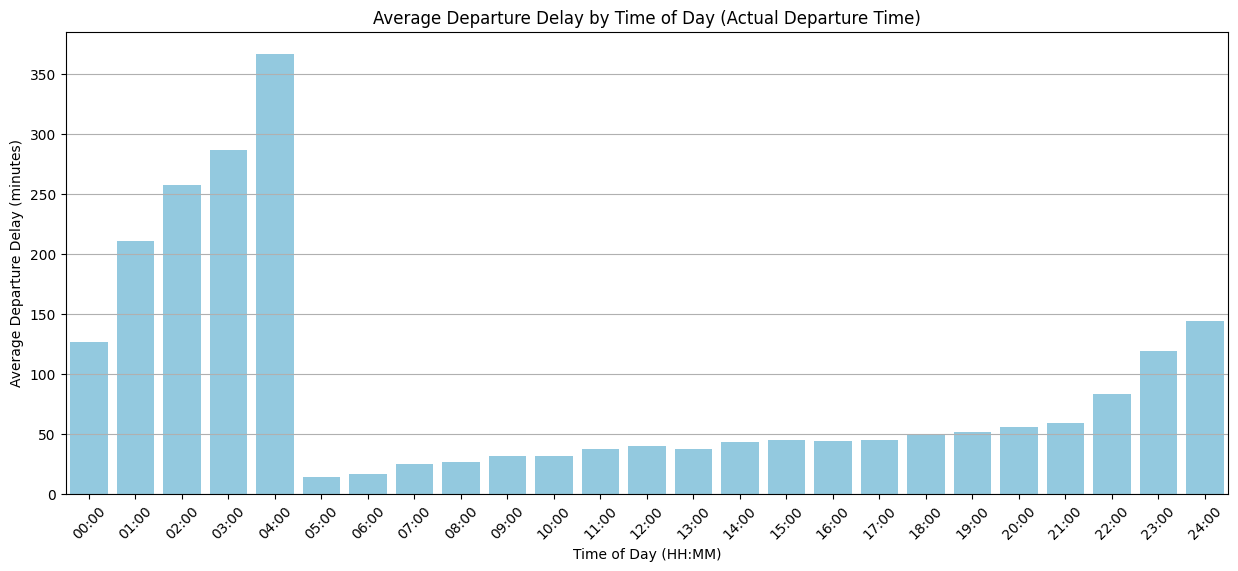

In [9]:
df['DepartureTimeHour'] = df['ActualDepartureTime'] // 100
departure_agg_data = df.groupby('DepartureTimeHour')['DepartureDelayInMinutes'].mean().reset_index()

# Ensure 'DepartureTimeHour' is integer for formatting
departure_agg_data['DepartureTimeHour'] = departure_agg_data['DepartureTimeHour'].astype(int)

# Format the hour for better readability
departure_agg_data['FormattedHour'] = departure_agg_data['DepartureTimeHour'].apply(lambda x: f'{x:02d}:00')

plt.figure(figsize=(15, 6))
sns.barplot(x='FormattedHour', y='DepartureDelayInMinutes', data=departure_agg_data, color='skyblue')
plt.xticks(rotation=45)
plt.title('Average Departure Delay by Time of Day (Actual Departure Time)')
plt.xlabel('Time of Day (HH:MM)')
plt.ylabel('Average Departure Delay (minutes)')
plt.grid(axis='y')
plt.show()


Analyzing the data, we observe distinct patterns. Early morning flights, from midnight to about 4 AM, encounter the most delay, most likely due to reduced pilot and plane availability. As the workday approaches, delay seems to drop precipitously until late night returns.  Understanding these trends enhances travel planning and overall experience.



To pivot slightly, understanding the distribution of flight departures throughout the day is crucial for travelers aiming to optimize their trip. This offers valuable insights into the busiest and quietest hours at the airport, allowing passengers to plan their flights during less congested periods for a more seamless travel experience.

A count plot provides a clear overview of the hourly distribution of flight departures. Peaks in the graph indicate periods of higher air traffic, potentially leading to longer wait times and congestion at the airport. On the contrary, valleys suggest quieter hours with fewer flights, offering travelers an opportunity to avoid the hustle and bustle associated with peak times.


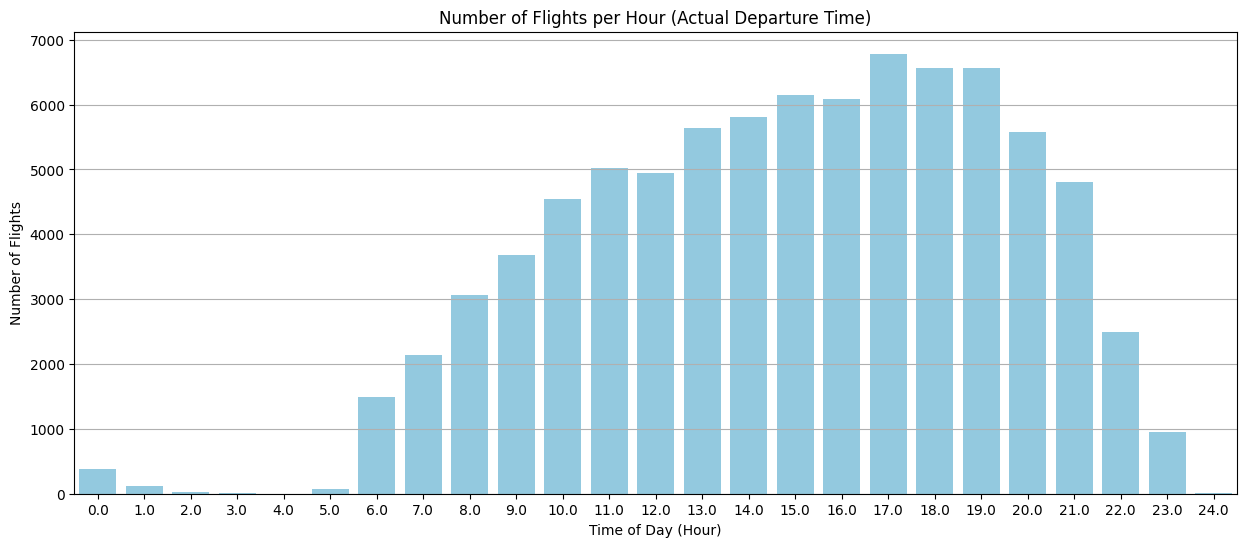

In [10]:
df['DepartureTimeHour'] = df['ActualDepartureTime'] // 100

plt.figure(figsize=(15, 6))
sns.countplot(x='DepartureTimeHour', data=df, color='skyblue')
plt.title('Number of Flights per Hour (Actual Departure Time)')
plt.xlabel('Time of Day (Hour)')
plt.ylabel('Number of Flights')
plt.grid(axis='y')
plt.show()


Examining the plot provides insights into the temporal dynamics of flight numbers. The initial dip in flights around midnight can be attributed to reduced air travel demand during late hours. The subsequent decline from 1 AM to 4 AM may result from scheduling adjustments and decreased passenger activity. The noticeable uptick starting at 5 AM, with a gradual increase until the peak at 7 PM, likely reflects the resumption of daily air travel patterns and higher demand during daylight hours.

This confirms our assumption about increases and decreases in delay times by the hour of the day.



It would be useful to have insights into the comparative performance of the busiest airlines as it concerns average departure delays. By presenting the information graphically, it facilitates a quick and easy assessment of each airline's punctuality, and gives some insight as to whether we might be able to predict delay if we know what airline a passenger is flying.

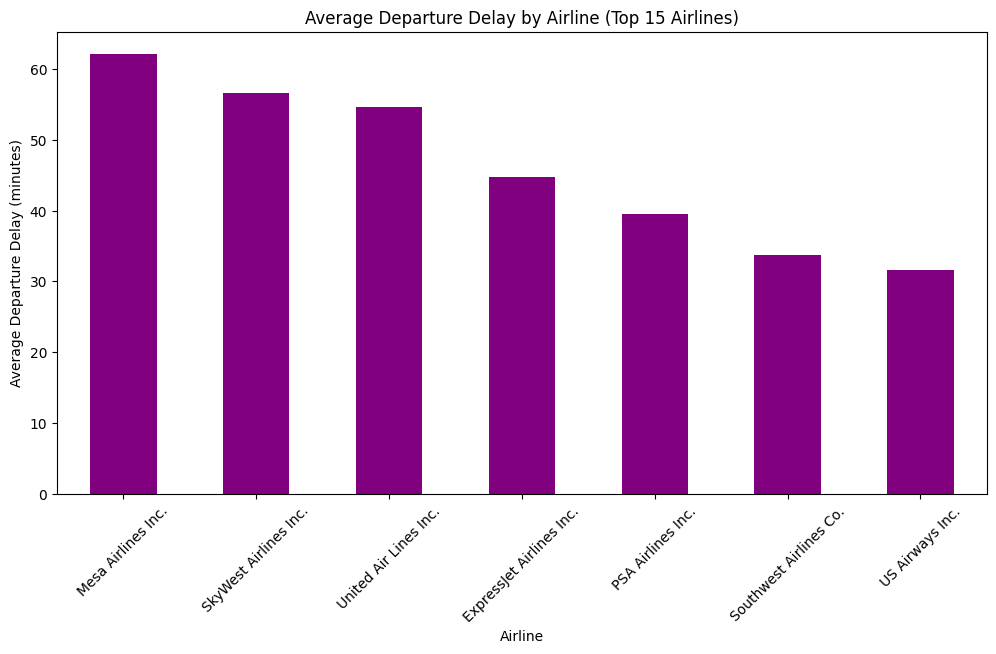

In [11]:
# Identify the top 15 airlines by the number of flights
top_airlines = df['AirlineName'].value_counts().nlargest(15).index

# Filter the DataFrame to only include the top airlines
df_top_airlines = df[df['AirlineName'].isin(top_airlines)]

# Calculate the average delay for each of these top airlines
avg_delay_by_airline = df_top_airlines.groupby('AirlineName')['DepartureDelayInMinutes'].mean().sort_values(ascending=False)

# Plotting Average Delays for Top 15 Airlines
plt.figure(figsize=(12, 6))
avg_delay_by_airline.plot(kind='bar', color='purple')
plt.title('Average Departure Delay by Airline (Top 15 Airlines)')
plt.xlabel('Airline')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(rotation=45)
plt.show()

We can see that Mesa Airlines and JetBlue Airways show the highest delays. On the contrary, US Airways and Southwest Airlines consistently demonstrate the lowest delays. This contrast in delay patterns highlights the varying operational efficiencies among the airlines, and shows that although there are some upticks in wait times for certain carriers, the average wait times are generally about the same.


It might be worth visualizing the impact of seasonality on delay. Do delays increase in colder weather when snowstorms are more common, or perhaps in the Summer months when more people are presumably traveling?

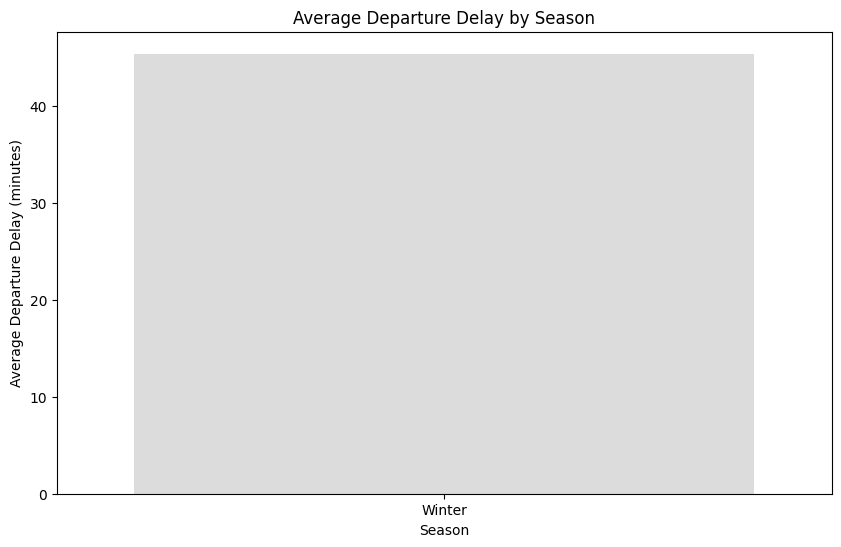

In [12]:
def categorize_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'


df['Season'] = df['Month'].apply(categorize_season)
avg_delay_by_season = df.groupby('Season')['DepartureDelayInMinutes'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_delay_by_season.index, y=avg_delay_by_season.values, palette='coolwarm')
plt.title('Average Departure Delay by Season')
plt.xlabel('Season')
plt.ylabel('Average Departure Delay (minutes)')
plt.show()


The bar plot indeed reveals increased average departure delays in winter and summer, around 50 minutes, and that could be attributed to adverse weather conditions, increases in traffic, or a combination of all those factors. The winter season, coinciding with holiday traffic and potential disruptions, likely further exacerbates delays.

Finally, it might be useful to see whether the airport someone is flying into or out of has any bearing on their expected delay time. Are certain airports more likely than others to have longer waits?

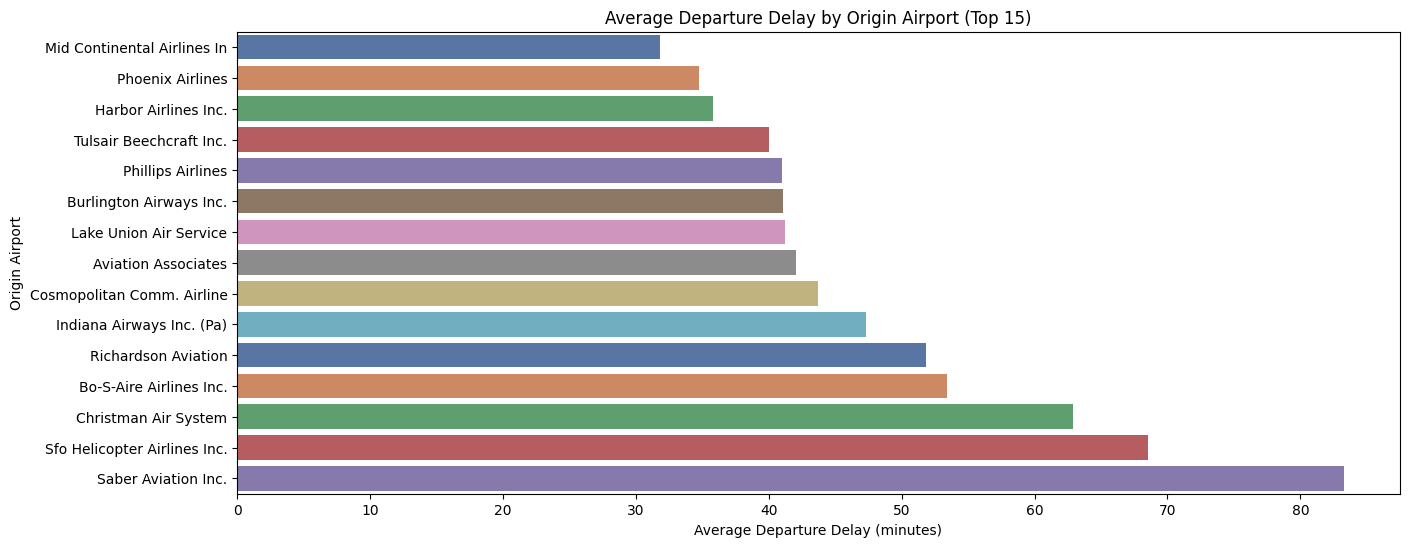

In [13]:
top_15_origin = df['OriginAirportName'].value_counts().nlargest(15).index

# Filter for top 15 origin airports
df_top_origin = df[df['OriginAirportName'].isin(top_15_origin)]

# Calculate average departure delay
avg_departure_delay_origin = df_top_origin.groupby('OriginAirportName')['DepartureDelayInMinutes'].mean().reset_index()
avg_departure_delay_sorted = avg_departure_delay_origin.sort_values(by='DepartureDelayInMinutes')

# Plot
plt.figure(figsize=(15, 6))
sns.barplot(x='DepartureDelayInMinutes', y='OriginAirportName', data=avg_departure_delay_sorted, palette='deep', orient='h')
plt.title('Average Departure Delay by Origin Airport (Top 15)')
plt.xlabel('Average Departure Delay (minutes)')
plt.ylabel('Origin Airport')
plt.show()



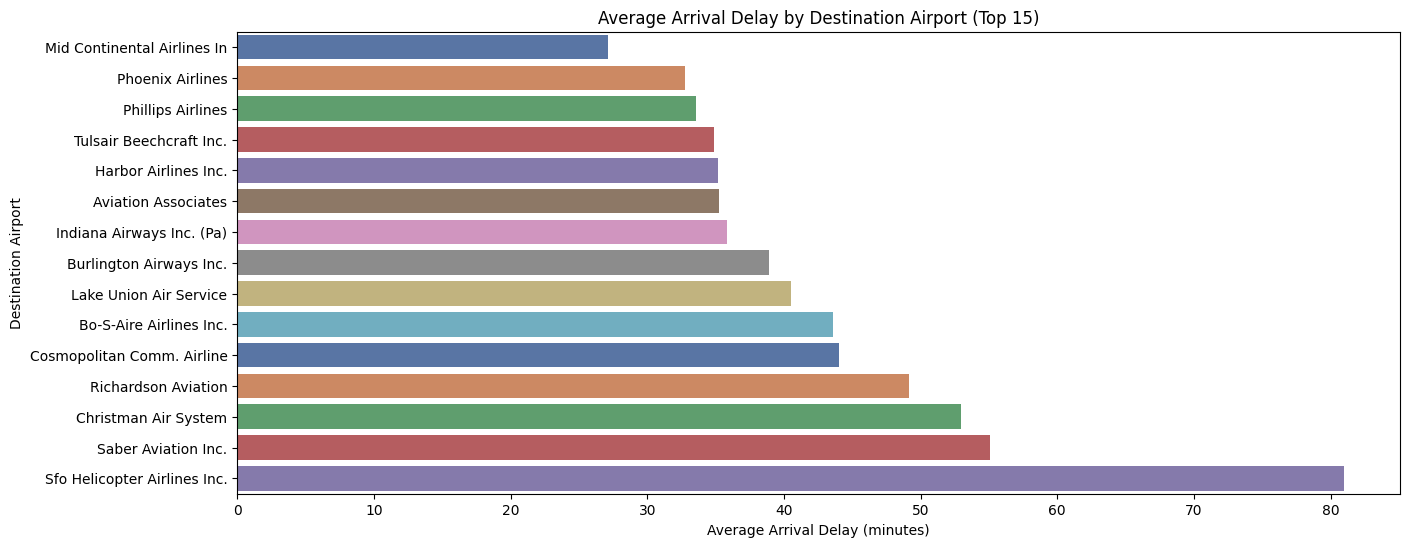

In [14]:
top_15_dest = df['DestinationAirportName'].value_counts().nlargest(15).index

# Filter for top 15 destination airports
df_top_dest = df[df['DestinationAirportName'].isin(top_15_dest)]

# Calculate average arrival delay
avg_arrival_delay_dest = df_top_dest.groupby('DestinationAirportName')['ArrivalDelayInMinutes'].mean().reset_index()

# Sorting the data in ascending order based on average arrival delay
avg_arrival_delay_dest_sorted = avg_arrival_delay_dest.sort_values(by='ArrivalDelayInMinutes')

# Plot
plt.figure(figsize=(15, 6))
sns.barplot(x='ArrivalDelayInMinutes', y='DestinationAirportName', data=avg_arrival_delay_dest_sorted, palette='deep', orient='h')
plt.title('Average Arrival Delay by Destination Airport (Top 15)')
plt.xlabel('Average Arrival Delay (minutes)')
plt.ylabel('Destination Airport')
plt.show()

These plots show that many of the same airports have longer delays, with the order seeming to vary more for the arrival delays. There could be systemic reasons for this, traffic-related explanations, process bottlenecks, or otherwise. Without more specific data, it's hard to say.

# Machine Learning Preprocessing

Define Predictors and target, encode, split into training/test

In [15]:

# Define the target variable
target = df['DelayCategory']

# Explicitly declaring the columns to use as predictors
predictor_columns = [
    'DayOfWeek', 'CarrierCode', 'OriginAirportCode', 'DestinationAirportCode',
    'FlightDistance', 'TaxiInTimeInMinutes', 'TaxiOutTimeInMinutes', 'AirlineName',
    'OriginAirportName', 'DestinationAirportName', 'ScheduledDepartureTime', 'Season'
]

# Extracting only the specified predictor columns
predictors = df[predictor_columns]

# Apply one-hot encoding to the categorical predictor variables
df_encoded = pd.get_dummies(predictors, drop_first=True)

# Extracting predictor variables
X = df_encoded.values  # df_encoded now contains only the specified and encoded predictors
y = target.values

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Baseline Accuracy

In [16]:
# Determine the most frequent class for baseline accuracy
most_frequent_class = pd.Series(y_train).mode()[0]
baseline_predictions = [most_frequent_class] * len(y_test)
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
print(f'Baseline Accuracy:{baseline_accuracy:.2f}')


Baseline Accuracy:0.44


Machine Learning Prep

> Note: There was a GridSearch CV block, and it was removed because it took about 2 hours to run on this dataset. The optimal max_depth given by the GridSearch was max_depth=13.


In [17]:
clf = DecisionTreeClassifier(max_depth=13, random_state=42)
clf.fit(X_train, y_train)



DecisionTreeClassifier(max_depth=13, random_state=42)

#Predict

In [18]:
# Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.2f}')
print("\nClassification Report:\n", class_report)


Test Accuracy: 0.48

Classification Report:
                 precision    recall  f1-score   support

 Lengthy Delay       0.53      0.68      0.60      7365
Moderate Delay       0.42      0.46      0.44      6081
      No Delay       0.31      0.06      0.10      3135

      accuracy                           0.48     16581
     macro avg       0.42      0.40      0.38     16581
  weighted avg       0.45      0.48      0.45     16581



Feature importances

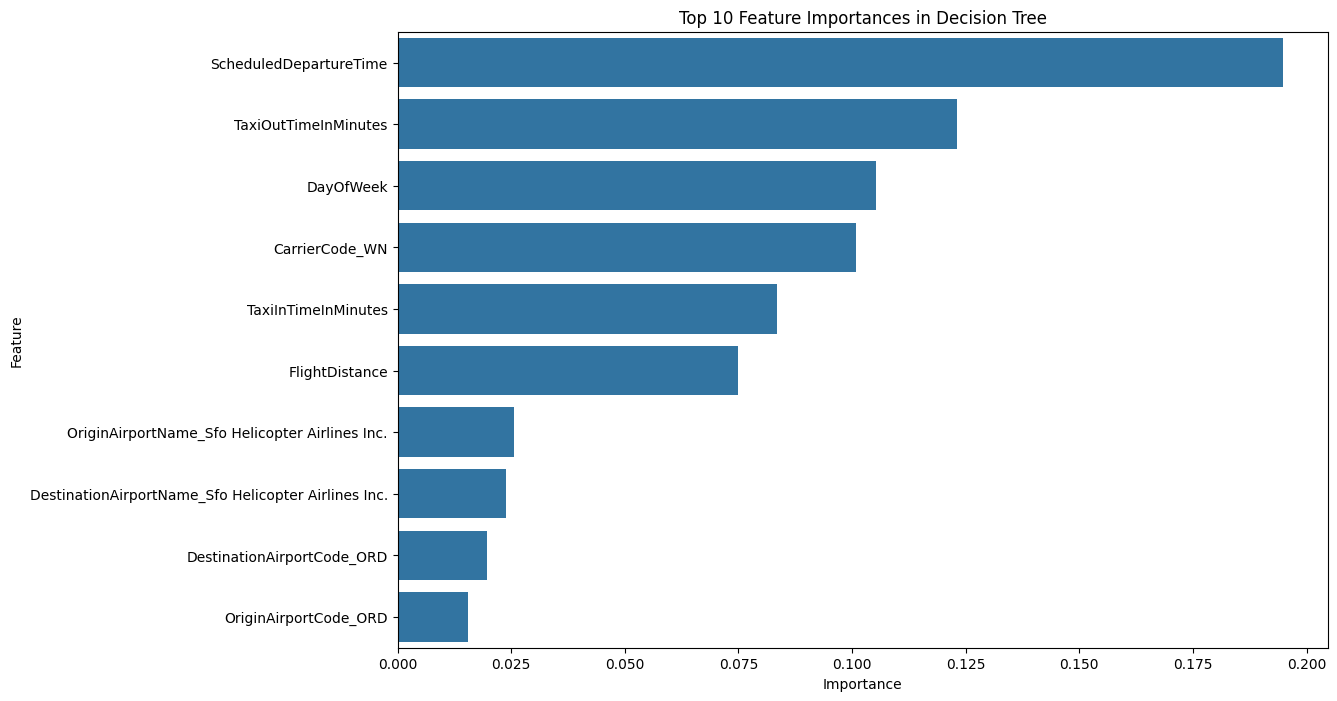

In [19]:
feature_importances = clf.feature_importances_

# Ensure the length of feature importances matches the number of columns in df_encoded
if len(feature_importances) == len(df_encoded.columns):
    top_features = pd.Series(feature_importances, index=df_encoded.columns).sort_values(ascending=False).head(10)

    # Plot the top 10 feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title('Top 10 Feature Importances in Decision Tree')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
else:
    print("Mismatch in the number of features between the model and the encoded DataFrame.")



##Conclusion

I developed a Decision Tree Classifier to predict the category of delay of a flight based on features like depature time hour, day of week, and distance. The model classifies delays into three categories: No Delay (10 minutes or less), Moderate Delay (10 to 30 minutes), and Lengthy Delay (more than 30 minutes). Our baseline accuracy was 42%, we were able to achieve a test accuracy of 46%. The most interesting thing about these results is the extent to which the scheduled departure time of the passenger plays into the algorithm's prediction. The next step here would be another iteration of this process, perhaps after some more feature engineering.

The number of samples supporting the No Delay category were signifcantly less than the samples for the other classes, so the natural inclination is to suspect feature imbalance. Given the size of the dataset and the time consumed in training and predicting the Decision Tree Classifier for what ultimately seems to be minimal gains in overall accuracy, it may be worth trying other algorithms.


After examining the top 10 important features we found that the most influencial factor was departure time hour followed by flight distance. This tells us that overwhelmingly, the greatest indicator of a consumer's wait time is the time that they are scheduled to leave the airport. This aligns with the exploratory analysis that indicated certain times of day are significantly more delay-prone than others, but all times of day can generally expect a delay of some sort. This, in fact, is likely why the "No delay" category has such a low recall and f-1 score -- there are simply fewer instances of having no wait at airports, regardless of carrier or airport. Ultimately, we did not make significant enough improvements over the baseline to consider this model reliable.